In [1]:
%%time

from pysme.synthesize import synthesize_spectrum
from pysme.linelist.linelist import LineList
from pysme.linelist.vald import ValdFile
from pysme.sme import SME_Structure
from pysme.util import vac2air
from pysme.solve import solve
from pysme.abund import Abund
from pysme import util

from scipy.interpolate import interp1d
from joblib import Parallel, delayed
from scipy.signal import find_peaks
from astropy.constants import c
import matplotlib.pyplot as plt
from io import StringIO
import pandas as pd
import numpy as np
import warnings
import glob
import sys
import os
import gc

warnings.filterwarnings('ignore')

CPU times: user 1.29 s, sys: 194 ms, total: 1.48 s
Wall time: 1.68 s


In [2]:
os.chdir('/home/fgran/iSpec/')
import ispec
sys.path.append('/home/fgran/iSpec/')

In [3]:
def pix_to_wl(pix, wl0, dwl):
    return wl0 + pix * dwl

In [4]:
os.environ['NUMEXPR_MAX_THREADS'] = '35' #change this number using the correct number of cores/threads in jupyter.slurm

In [5]:
#Load Cayrel-LP results

In [6]:
os.chdir('/store/teams/cosmos/fgran/data/Pristine-UVES/')
stars = sorted(glob.glob('/store/teams/cosmos/hill/hill_extern7bis/LP/LPgiants/*/'))[:-1]

In [7]:
cayrel = pd.read_csv('tmp_merged/cayrel_atm_fe_cn.csv')

In [8]:
cayrel.head(2)

,spec_id,teff,eteff_sme,eteff_fit,logg,elogg_sme,elogg_fit,monh,emonh_sme,emonh_fit,...,is_limit_n_cn_s05,n_nh_s05,en_nh_s05,is_limit_n_nh_s05,nh_adopted_s05,is_limit_nh_adopted_s05,oh_s05,cnfe_s05,is_limit_cnfe_s05,mixed_s05
0,01_HD2796,4939.899305,204.934803,11.533078,1.851909,0.047986,0.047986,-2.349789,0.215940,0.013301,...,False,-1.22,0.08,False,-1.62,False,-1.97,0.14,False,m
1,02_HD122563,4581.238720,163.183116,8.732404,1.328129,0.060962,0.060962,-2.679967,0.186471,0.010661,...,False,-1.72,0.15,False,-2.12,False,-2.20,0.04,False,m


In [9]:
linelist = ValdFile('linelist/3800-6800_long.lin')

wmin_blue = 3800 #3800
wmax_blue = 4975
wmax_blue = 5800

linelist = linelist[(linelist.wlcent > wmin_blue) & (linelist.wlcent < wmax_blue)]

#Delta lines definitions
delta_line = 1. #AA
delta_cont = 1.5 #AA
delta_cont_Ca = 25 #AA

wl_G_band = 4300. #AA
delta_G_band = 40. #AA
wl_CaHK_band = 3950. #AA
delta_CaHK_band = 50. #AA
delta_H_line_wing = 5.0 #AA
delta_H_line_core = 0.75 #AA

[2025-04-22 11:07:32,683] [INFO] [vald:loads:174]: Loading VALD file linelist/3800-6800_long.lin


INFO - Loading VALD file linelist/3800-6800_long.lin


In [10]:
%%time

#Only for n-capture elements

linelist = pd.DataFrame(ValdFile('linelist/3800-6800_long.lin'))
linelist = linelist[~linelist.species.str.contains('Sr|Ce|Gd|Hf|Ir|Os|Pb|Pr|Sm|Th|Tm|U|Ba|Dy|Er|Eu|La|Nd|Y|Zr', regex=True, case=True).values] #Remove n-capture transitions from the linelist

wmin_blue = 3800
wmax_blue = 5800

lls_names = ['linelist/Eu_VALD_all.lin', 'linelist/Sr_VALD_all.lin', 'linelist/Ba_VALD_all.lin', 'linelist/Ce_VALD_all.lin', 
       'linelist/Dy_VALD_all.lin', 'linelist/Er_VALD_all.lin', 'linelist/Gd_VALD_all.lin', 'linelist/Hf_VALD_all.lin', 'linelist/Ir_VALD_all.lin',
       'linelist/La_VALD_all.lin', 'linelist/Nd_VALD_all.lin', 'linelist/Os_VALD_all.lin', 'linelist/Pb_VALD_all.lin',
       'linelist/Pr_VALD_all.lin', 
       'linelist/Sm_VALD_all.lin', 'linelist/Th_VALD_all.lin', 'linelist/Tm_VALD_all.lin', 'linelist/U_VALD_all.lin',
       'linelist/Y_VALD_all.lin', 'linelist/Zr_VALD_all.lin']

lls_ions = ['2', '2', '2', '2',
       '2', '2', '2', '2', '1',
       '2', '2', '1', '1',
       '2',
       '2', '2', '2', '2',
       '2', '2']

for ll_name, ll_ion in zip(lls_names, lls_ions):

    print(ll_name, ll_ion)
    ll = pd.DataFrame(ValdFile(ll_name))

    if 'Eu_' in ll_name:
        ll = ll.query('abs(wlcent - 3930.499) < 2.0 or abs(wlcent - 4129.725) < 2.0 or abs(wlcent - 4205.042) < 2.0 or abs(wlcent - 4435.578) < 2.0 or abs(wlcent - 4522.581) < 2.0')
    if 'Sr_' in ll_name:
        ll = ll.query('abs(wlcent - 4077.709) < 2.0 or abs(wlcent - 4161.792) < 2.0 or abs(wlcent - 4215.519) < 2.0')
    if 'Ba_' in ll_name:
        ll = ll.query('abs(wlcent - 3891.776) < 2.0 or abs(wlcent - 4130.645) < 2.0 or abs(wlcent - 4554.029) < 2.0 or abs(wlcent - 4934.076) < 2.0 or abs(wlcent - 5853.668) < 2.0')
    if 'Ce_' in ll_name:
        ll = ll.query('abs(wlcent - 4073.474) < 2.0 or abs(wlcent - 4083.222) < 2.0 or abs(wlcent - 4120.827) < 2.0 or abs(wlcent - 4127.364) < 2.0 or abs(wlcent - 4222.597) < 2.0\
          or abs(wlcent - 4418.780) < 2.0 or abs(wlcent - 4486.909) < 2.0 or abs(wlcent - 4562.359) < 2.0 or abs(wlcent - 4628.161) < 2.0')
    if 'Dy_' in ll_name:
        ll = ll.query('abs(wlcent - 3869.864) < 2.0 or abs(wlcent - 3996.689) < 2.0 or abs(wlcent - 4011.285) < 2.0 or abs(wlcent - 4103.306) < 2.0 or abs(wlcent - 4468.138) < 2.0\
          or abs(wlcent - 5169.688) < 2.0')
    if 'Er_' in ll_name:
        ll = ll.query('abs(wlcent - 3692.649) < 2.0 or abs(wlcent - 3786.836) < 2.0 or abs(wlcent - 3830.482) < 2.0 or abs(wlcent - 3896.234) < 2.0 or abs(wlcent - 3938.626) < 2.0')
    if 'Gd_' in ll_name:
        ll = ll.query('abs(wlcent - 3768.396) < 2.0 or abs(wlcent - 3796.384) < 2.0 or abs(wlcent - 3836.915) < 2.0 or abs(wlcent - 3844.578) < 2.0 or abs(wlcent - 3916.509) < 2.0\
          or abs(wlcent - 4037.893) < 2.0 or abs(wlcent - 4085.558) < 2.0 or abs(wlcent - 4130.366) < 2.0 or abs(wlcent - 4191.075) < 2.0')
    if 'Hf_' in ll_name:
        ll = ll.query('abs(wlcent - 3399.793) < 2.0 or abs(wlcent - 3719.276) < 2.0')
    if 'Ir_' in ll_name:
        ll = ll.query('abs(wlcent - 3800.120) < 2.0')
    if 'La_' in ll_name:
        ll = ll.query('abs(wlcent - 3849.006) < 2.0 or abs(wlcent - 4086.709) < 2.0 or abs(wlcent - 4123.218) < 2.0 or abs(wlcent - 5122.988) < 2.0 or abs(wlcent - 6320.376) < 2.0')
    if 'Nd_' in ll_name:
        ll = ll.query('abs(wlcent - 3973.260) < 2.0 or abs(wlcent - 4018.823) < 2.0 or abs(wlcent - 4021.327) < 2.0 or abs(wlcent - 4061.080) < 2.0 or abs(wlcent - 4069.265) < 2.0\
          or abs(wlcent - 4109.448) < 2.0 or abs(wlcent - 4232.374) < 2.0 or abs(wlcent - 4446.384) < 2.0 or abs(wlcent - 4462.979) < 2.0 or abs(wlcent - 5130.586) < 2.0\
          or abs(wlcent - 5212.361) < 2.0 or abs(wlcent - 5234.194) < 2.0 or abs(wlcent - 5249.576) < 2.0 or abs(wlcent - 5293.163) < 2.0 or abs(wlcent - 5311.453) < 2.0\
          or abs(wlcent - 5319.815) < 2.0 or abs(wlcent - 5361.467) < 2.0 or abs(wlcent - 5442.264) < 2.0')
    if 'Os_' in ll_name:
        ll = ll.query('abs(wlcent - 4135.775) < 2.0 or abs(wlcent - 4260.848) < 2.0 or abs(wlcent - 4420.468) < 2.0')
    if 'Pb_' in ll_name:
        ll = ll.query('abs(wlcent - 4057.807) < 2.0')
    if 'Pr_' in ll_name:
        ll = ll.query('abs(wlcent - 3964.262) < 2.0 or abs(wlcent - 3964.812) < 2.0 or abs(wlcent - 3965.253) < 2.0 or abs(wlcent - 4062.805) < 2.0 or abs(wlcent - 5220.108) < 2.0\
          or abs(wlcent - 5259.728) < 2.0')
    if 'Sm_' in ll_name:
        ll = ll.query('abs(wlcent - 3896.972) < 2.0 or abs(wlcent - 4023.222) < 2.0 or abs(wlcent - 4068.324) < 2.0 or abs(wlcent - 4318.927) < 2.0 or abs(wlcent - 4499.475) < 2.0\
          or abs(wlcent - 4519.630) < 2.0 or abs(wlcent - 4537.941) < 2.0 or abs(wlcent - 4577.688) < 2.0')
    if 'Th_' in ll_name:
        ll = ll.query('abs(wlcent - 4019.129) < 2.0 or abs(wlcent - 4086.521) < 2.0 or abs(wlcent - 4094.747) < 2.0')
    if 'Tm_' in ll_name:
        ll = ll.query('abs(wlcent - 3848.020) < 2.0')
    if 'U_' in ll_name:
        ll = ll.query('abs(wlcent - 3859.571) < 2.0')
    if 'Y_' in ll_name:
        ll = ll.query('abs(wlcent - 3818.341) < 2.0 or abs(wlcent - 3950.352) < 2.0 or abs(wlcent - 4398.013) < 2.0 or abs(wlcent - 4883.684) < 2.0 or abs(wlcent - 5087.416) < 2.0\
          or abs(wlcent - 5123.211) < 2.0 or abs(wlcent - 5200.406) < 2.0 or abs(wlcent - 5205.724) < 2.0')
    if 'Zr_' in ll_name:
        ll = ll.query('abs(wlcent - 3836.762) < 2.0 or abs(wlcent - 4161.213) < 2.0 or abs(wlcent - 4208.977) < 2.0 or abs(wlcent - 4317.299) < 2.0 or abs(wlcent - 4496.980) < 2.0')

    linelist = pd.concat([linelist, ll[ll.species.str.contains(ll_ion)]])
    # linelist = linelist[linelist.species.str.contains('1') | linelist.species.str.contains('2')]
    linelist = linelist[linelist.gflog > -3]

#Ba r-process scaled
linelist.gflog[linelist.reference.str.contains('130')] = -7.0
linelist.gflog[linelist.reference.str.contains('132')] = -7.0
linelist.gflog[linelist.reference.str.contains('134')] = -7.0
linelist.gflog[linelist.reference.str.contains('135')] = np.log10(0.40 * 10**linelist.gflog.values)
linelist.gflog[linelist.reference.str.contains('136')] = -7.0
linelist.gflog[linelist.reference.str.contains('137')] = np.log10(0.32 * 10**linelist.gflog.values)
linelist.gflog[linelist.reference.str.contains('138')] = np.log10(0.28 * 10**linelist.gflog.values)

linelist = LineList(linedata=linelist, medium='air').sort()
# linelist = LineList(linelist)

linelist = linelist[(linelist.wlcent > wmin_blue) & (linelist.wlcent < wmax_blue)]

print('Nlines in the linelist: %d' %linelist.species.size)

[2025-04-22 11:07:37,942] [INFO] [vald:loads:174]: Loading VALD file linelist/3800-6800_long.lin


INFO - Loading VALD file linelist/3800-6800_long.lin


[2025-04-22 11:07:38,308] [INFO] [vald:loads:174]: Loading VALD file linelist/Eu_VALD_all.lin


linelist/Eu_VALD_all.lin 2
INFO - Loading VALD file linelist/Eu_VALD_all.lin


[2025-04-22 11:07:38,881] [WARNING] [vald:parse_references:558]: Could not find citation key: MZH
[2025-04-22 11:07:38,903] [INFO] [vald:loads:174]: Loading VALD file linelist/Sr_VALD_all.lin


WARNING - Could not find citation key: MZH
linelist/Sr_VALD_all.lin 2
INFO - Loading VALD file linelist/Sr_VALD_all.lin


[2025-04-22 11:07:39,288] [INFO] [vald:loads:174]: Loading VALD file linelist/Ba_VALD_all.lin


linelist/Ba_VALD_all.lin 2
INFO - Loading VALD file linelist/Ba_VALD_all.lin


[2025-04-22 11:07:40,488] [INFO] [vald:loads:174]: Loading VALD file linelist/Ce_VALD_all.lin


linelist/Ce_VALD_all.lin 2
INFO - Loading VALD file linelist/Ce_VALD_all.lin


[2025-04-22 11:07:41,291] [WARNING] [vald:parse_references:558]: Could not find citation key: LCNWS
[2025-04-22 11:07:41,293] [WARNING] [vald:parse_references:558]: Could not find citation key: MZH
[2025-04-22 11:07:41,455] [INFO] [vald:loads:174]: Loading VALD file linelist/Dy_VALD_all.lin


WARNING - Could not find citation key: LCNWS
WARNING - Could not find citation key: MZH
linelist/Dy_VALD_all.lin 2
INFO - Loading VALD file linelist/Dy_VALD_all.lin


[2025-04-22 11:07:42,145] [WARNING] [vald:parse_references:558]: Could not find citation key: MZH
[2025-04-22 11:07:42,166] [INFO] [vald:loads:174]: Loading VALD file linelist/Er_VALD_all.lin


WARNING - Could not find citation key: MZH
linelist/Er_VALD_all.lin 2
INFO - Loading VALD file linelist/Er_VALD_all.lin


[2025-04-22 11:07:42,825] [WARNING] [vald:parse_references:558]: Could not find citation key: MZH
[2025-04-22 11:07:42,846] [INFO] [vald:loads:174]: Loading VALD file linelist/Gd_VALD_all.lin


WARNING - Could not find citation key: MZH
linelist/Gd_VALD_all.lin 2
INFO - Loading VALD file linelist/Gd_VALD_all.lin


[2025-04-22 11:07:43,767] [WARNING] [vald:parse_references:558]: Could not find citation key: MZH
[2025-04-22 11:07:43,792] [INFO] [vald:loads:174]: Loading VALD file linelist/Hf_VALD_all.lin


WARNING - Could not find citation key: MZH
linelist/Hf_VALD_all.lin 2
INFO - Loading VALD file linelist/Hf_VALD_all.lin


[2025-04-22 11:07:44,314] [WARNING] [vald:parse_references:558]: Could not find citation key: DHLR
[2025-04-22 11:07:44,333] [INFO] [vald:loads:174]: Loading VALD file linelist/Ir_VALD_all.lin


WARNING - Could not find citation key: DHLR
linelist/Ir_VALD_all.lin 1
INFO - Loading VALD file linelist/Ir_VALD_all.lin


[2025-04-22 11:07:44,736] [INFO] [vald:loads:174]: Loading VALD file linelist/La_VALD_all.lin


linelist/La_VALD_all.lin 2
INFO - Loading VALD file linelist/La_VALD_all.lin


[2025-04-22 11:07:45,584] [WARNING] [vald:parse_references:558]: Could not find citation key: MZH
[2025-04-22 11:07:45,618] [INFO] [vald:loads:174]: Loading VALD file linelist/Nd_VALD_all.lin


WARNING - Could not find citation key: MZH
linelist/Nd_VALD_all.lin 2
INFO - Loading VALD file linelist/Nd_VALD_all.lin


[2025-04-22 11:07:46,095] [WARNING] [vald:parse_references:558]: Could not find citation key: MZH
[2025-04-22 11:07:46,097] [WARNING] [vald:parse_references:558]: Could not find citation key: BWT
[2025-04-22 11:07:46,130] [INFO] [vald:loads:174]: Loading VALD file linelist/Os_VALD_all.lin


WARNING - Could not find citation key: MZH
WARNING - Could not find citation key: BWT
linelist/Os_VALD_all.lin 1
INFO - Loading VALD file linelist/Os_VALD_all.lin


[2025-04-22 11:07:47,337] [INFO] [vald:loads:174]: Loading VALD file linelist/Pb_VALD_all.lin


linelist/Pb_VALD_all.lin 1
INFO - Loading VALD file linelist/Pb_VALD_all.lin


[2025-04-22 11:07:47,655] [INFO] [vald:loads:174]: Loading VALD file linelist/Pr_VALD_all.lin


linelist/Pr_VALD_all.lin 2
INFO - Loading VALD file linelist/Pr_VALD_all.lin


[2025-04-22 11:07:48,350] [INFO] [vald:loads:174]: Loading VALD file linelist/Sm_VALD_all.lin


linelist/Sm_VALD_all.lin 2
INFO - Loading VALD file linelist/Sm_VALD_all.lin


[2025-04-22 11:07:48,924] [WARNING] [vald:parse_references:558]: Could not find citation key: MZH
[2025-04-22 11:07:48,947] [INFO] [vald:loads:174]: Loading VALD file linelist/Th_VALD_all.lin


WARNING - Could not find citation key: MZH
linelist/Th_VALD_all.lin 2
INFO - Loading VALD file linelist/Th_VALD_all.lin


[2025-04-22 11:07:49,447] [INFO] [vald:loads:174]: Loading VALD file linelist/Tm_VALD_all.lin


linelist/Tm_VALD_all.lin 2
INFO - Loading VALD file linelist/Tm_VALD_all.lin


[2025-04-22 11:07:51,672] [WARNING] [vald:parse_references:558]: Could not find citation key: MZH
[2025-04-22 11:07:51,710] [INFO] [vald:loads:174]: Loading VALD file linelist/U_VALD_all.lin


WARNING - Could not find citation key: MZH
linelist/U_VALD_all.lin 2
INFO - Loading VALD file linelist/U_VALD_all.lin


[2025-04-22 11:07:52,509] [INFO] [vald:loads:174]: Loading VALD file linelist/Y_VALD_all.lin


linelist/Y_VALD_all.lin 2
INFO - Loading VALD file linelist/Y_VALD_all.lin


[2025-04-22 11:07:53,182] [INFO] [vald:loads:174]: Loading VALD file linelist/Zr_VALD_all.lin


linelist/Zr_VALD_all.lin 2
INFO - Loading VALD file linelist/Zr_VALD_all.lin
Nlines in the linelist: 2670
CPU times: user 7.29 s, sys: 71.2 ms, total: 7.36 s
Wall time: 17.7 s


In [11]:
# ll = pd.DataFrame(ValdFile('linelist/Sr_VALD_all.lin'))
# pd.DataFrame(ll).query('abs(wlcent - 4077.709) < 2.0 or abs(wlcent - 4161.792) < 2.0 or abs(wlcent - 4215.519) < 2.0')

In [12]:
pd.DataFrame(linelist).query('species == "Ba 2"').wlcent.values

array([3891.776  , 4130.645  , 4553.99798, 4553.9991 , 4553.99934,
       4554.00093, 4554.00208, 4554.00245, 4554.031  , 4554.0315 ,
       4554.0319 , 4554.0323 , 4554.0336 , 4554.04788, 4554.05032,
       4554.05063, 4554.05179, 4554.0536 , 4554.05472, 4934.02976,
       4934.03388, 4934.04184, 4934.04468, 4934.0744 , 4934.075  ,
       4934.0755 , 4934.0758 , 4934.0773 , 4934.09223, 4934.09505,
       4934.10303, 4934.10714])

In [13]:
#Create solar scaled atmosphere with [alpha/Fe] = +0.4
solar = SME_Structure()
solar.abund = Abund(0.0, 'asplund2009')

abund = solar.abund.pattern
abund['O']  = abund['O']  + 0.4
abund['Ne'] = abund['Ne'] + 0.4
abund['Mg'] = abund['Mg'] + 0.4
abund['Si'] = abund['Si'] + 0.4
abund['S']  = abund['S']  + 0.4
abund['Ar'] = abund['Ar'] + 0.4
abund['Ca'] = abund['Ca'] + 0.4
abund['Ti'] = abund['Ti'] + 0.4

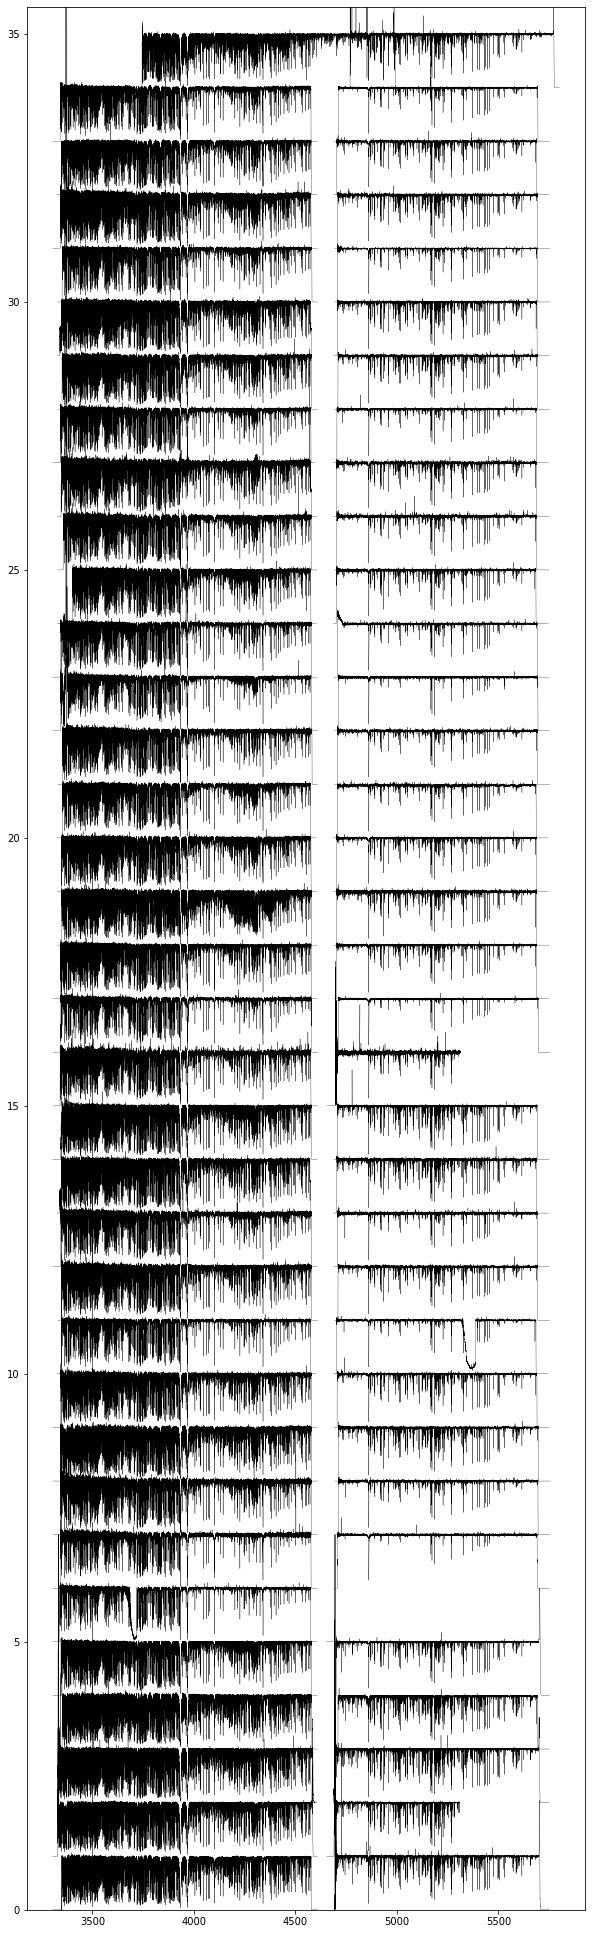

In [42]:
plt.figure(figsize=(10,35))
for i, star in enumerate(stars):
    try:
        header_spb = pd.read_csv('%s/spb' %star, nrows=1, skiprows=1, names=['npix', 'dpix', 'wl0', 'dwl', 'rv'], delim_whitespace=True)    
        data_spb = pd.read_csv('%s/spb' %star, nrows=header_spb.npix.values[0], skiprows=3, names=['pix', 'flux'], delim_whitespace=True, comment='-')
        data_spb.dropna(axis=0, inplace=True)
        
        wave_spb = pix_to_wl(data_spb.pix.values, header_spb.wl0.values[0], header_spb.dwl.values[0]) * np.sqrt((1.-(header_spb.rv[0]*1000.)/c.value)/(1.+(header_spb.rv[0]*1000.)/c.value))
        spec_spb = data_spb.flux.values/10000.
        uncs_spb = 0.001*np.ones_like(data_spb.flux.values)
        plt.plot(wave_spb, spec_spb+i, lw=0.3, color='k')
    except:
        pass
    try:
        header_spvl = pd.read_csv('%s/spvl' %star, nrows=1, skiprows=1, names=['npix', 'dpix', 'wl0', 'dwl', 'rv'], delim_whitespace=True)    
        data_spvl = pd.read_csv('%s/spvl' %star, nrows=header_spb.npix.values[0], skiprows=3, names=['pix', 'flux'], delim_whitespace=True, comment='-')
        data_spvl.dropna(axis=0, inplace=True)
    
        wave_spvl = pix_to_wl(data_spvl.pix.values, header_spvl.wl0.values[0], header_spvl.dwl.values[0]) * np.sqrt((1.-(header_spvl.rv[0]*1000.)/c.value)/(1.+(header_spvl.rv[0]*1000.)/c.value))
        spec_spvl = data_spvl.flux.values/10000.
        uncs_spvl = 0.001*np.ones_like(data_spvl.flux.values)
        plt.plot(wave_spvl, spec_spvl+i, lw=0.3, color='k')
    except:
        pass
    try:
        header_spvu = pd.read_csv('%s/spvu' %star, nrows=1, skiprows=1, names=['npix', 'dpix', 'wl0', 'dwl', 'rv'], delim_whitespace=True)    
        data_spvu = pd.read_csv('%s/spvu' %star, nrows=header_spb.npix.values[0], skiprows=3, names=['pix', 'flux'], delim_whitespace=True, comment='-')
        data_spvu.dropna(axis=0, inplace=True)
        
        wave_spvu = pix_to_wl(data_spvu.pix.values, header_spvu.wl0.values[0], header_spvu.dwl.values[0]) * np.sqrt((1.-(header_spvu.rv[0]*1000.)/c.value)/(1.+(header_spvu.rv[0]*1000.)/c.value))
        spec_spvu = data_spvu.flux.values/10000.
        uncs_spvu = 0.001*np.ones_like(data_spvu.flux.values)
        # plt.plot(wave_spvu, spec_spvu+i, lw=0.3, color='k')
    except:
        pass
    try:
        header_sprl = pd.read_csv('%s/sprl' %star, nrows=1, skiprows=1, names=['npix', 'dpix', 'wl0', 'dwl', 'rv'], delim_whitespace=True)    
        data_sprl = pd.read_csv('%s/sprl' %star, nrows=header_spb.npix.values[0], skiprows=3, names=['pix', 'flux'], delim_whitespace=True, comment='-')
        data_sprl.dropna(axis=0, inplace=True)
        
        wave_sprl = pix_to_wl(data_sprl.pix.values, header_sprl.wl0.values[0], header_sprl.dwl.values[0]) * np.sqrt((1.-(header_sprl.rv[0]*1000.)/c.value)/(1.+(header_sprl.rv[0]*1000.)/c.value))
        spec_sprl = data_sprl.flux.values/10000.
        uncs_sprl = 0.001*np.ones_like(data_sprl.flux.values)
        # plt.plot(wave_sprl, spec_sprl+i, lw=0.3, color='k')
    except:
        pass

plt.ylim(0, 35.5)
plt.show()

In [43]:
#Uncs. scaling parameters
percentile, percentile_sig_down, percentile_sig_up = 85, 0.25, 0.75

In [44]:
# def estimate_uncertainties_nice(resid, deriv, percentile, percentile_sig_down, percentile_sig_up):
#         """
#         Estimate the uncertainties by fitting the cumulative distribution of
#         derivative / uncertainties vs. residual / derivative
#         with the generalized normal distribution and use the 68% percentile
#         as the 1 sigma approximation for a normally distributed variable

#         Parameters
#         ----------
#         unc : array of shape (n,)
#             uncertainties
#         resid : array of shape (n,)
#             residuals of the least squares fit
#         deriv : array of shape (n, p)
#             derivatives (jacobian) of the least squares fit for each parameter

#         Returns
#         -------
#         freep_unc : array of shape (p,)
#             uncertainties for each free paramater, in the same order as self.parameter_names
#         """

#         nparameters = deriv.shape[1]
#         freep_unc = np.zeros(nparameters)

#         for i in range(nparameters):
#             pder = deriv[:, i]
#             #Change #1
#             # idx = pder != 0
#             idx = np.abs(pder) > np.percentile(np.abs(pder), percentile)
#             idx &= np.isfinite(pder)

#             if np.count_nonzero(idx) <= 5:
#                 logger.warning(
#                     "Not enough data points with a suitable derivative "
#                     "to determine the uncertainties"
#                 )
#                 continue
#             # Sort pixels according to the change of the i
#             # parameter needed to match the observations
#             idx_sort = np.argsort(resid[idx] / pder[idx])
#             ch_x = resid[idx][idx_sort] / pder[idx][idx_sort]
#             # Weights of the individual pixels also sorted
#             # uncertainties are already included in pder / unc[idx][idx_sort]
#             ch_y = np.abs(pder[idx][idx_sort])
#             # ch_y = np.abs(pder / unc[idx][idx_sort])
#             # Cumulative weights
#             ch_y = np.cumsum(ch_y)
#             # Normalized cumulative weights
#             ch_y /= ch_y[-1]

#             # hmed = np.interp(0.5, ch_y, ch_x)
#             interval = np.interp([percentile_sig_down, percentile_sig_up], ch_y, ch_x)
#             sigma_estimate = (interval[1] - interval[0]) / 2.
#             freep_unc[i] = sigma_estimate

#         return freep_unc

In [45]:
def sme_init(wave, spec, uncs, teff, logg, monh, vmic, vmac, abund, vrad_flag, linelist, ipress, vrad_bounds, elems_to_include):

    #SME definitions
    sme = SME_Structure()
    
    sme.ipres, sme.iptype, sme.gam6, sme.h2broad = ipress, 'gauss', True, True
    sme.atmo.source, sme.atmo.method, sme.atmo.geom = 'marcs2012s_t2.0.sav', 'grid', 'SPH'

    sme.accxt, sme.accgt, sme.accft = tol, tol, tol
    sme.leastsquare3_ftol, sme.leastsquares_gtol, sme.leastsquares_xtol = tol, tol, tol
    sme.accwi, sme.accrt, sme.clim, sme.chirat = tol, tol, tol, tol
    sme.vrad_bounds = vrad_bounds
    # sme.cscale_bounds = (0.99, 1.01)

    # Redirect output to logs/RUN*/*.txt
    util.start_logging(log_file='logs/Cayrel.txt', level='ERROR')

    sme.cscale_flag = 'constant'
    if elem_to_include == 'Al 1':
        sme.cscale_type = 'mcmc'
        sme.cscale_flag = 'linear'
    # sme.cscale_type = 'mcmc'
    sme.fitresults.maxiter = 100

    sme.wave = wave
    sme.spec = spec
    sme.uncs = uncs

    #Masking process to derive Teff, logg, monh and vmic (vmac if needed)
    # The mask values are: 0: bad pixel, 1: line pixel, 2: continuum pixel
    line_regions = np.ones_like(sme.wave.data).astype(int)
    # line_regions[(sme.spec.data > np.percentile(sme.spec.data, 90)) & (sme.spec.data < np.percentile(sme.spec.data, 95))] = 2
    ll_mask = np.zeros(linelist.species.size).astype(bool)
    
    for wline, mask_species in linelist[['wlcent', 'species']]:
        if mask_species in elems_to_include:
            idx_ = (sme.wave.data > wline-delta_line) & (sme.wave.data < wline+delta_line)
            line_regions[idx_] = 1
            
            ll_mask[(linelist.wlcent > wline-delta_line) & (linelist.wlcent < wline+delta_line)] = True
            continue
        
    # for wline, mask_species in linelist[['wlcent', 'species']]:
    #     #Hydrogen lines
    #     if 'H 1' == mask_species:
    #         idx_ = (sme.wave.data > wline-delta_H_line_core) & (sme.wave.data < wline+delta_H_line_core)
    #         line_regions[idx_] = 0
    del idx_
    
    #G-band and CaHK regions
    # line_regions[(sme.wave.data > wl_G_band-delta_G_band) & (sme.wave.data < wl_G_band+delta_G_band)] = 0
    # line_regions[(sme.wave.data > wl_CaHK_band-delta_CaHK_band) & (sme.wave.data < wl_CaHK_band+delta_CaHK_band)] = 0
    # line_regions[sme.wave.data < 4000] = 0
    #Merge all the line_regions as int
    line_regions = line_regions.astype(int)
    line_regions[sme.spec.data == 0.0] = 0
    sme.mask = line_regions
    del line_regions

    sme.linelist = linelist
    del ll_mask

    #Abundance scaling to create realistic synthetics
    sme.abund = abund
    #RV determination for each chip
    sme.vrad_flag = vrad_flag

    #input guesses from xgboost
    sme.teff = teff
    sme.logg = logg
    sme.monh = monh
    sme.vmic = vmic
    sme.vmac = vmac
    
    return sme

In [65]:
def Cayrel_LP(i, star, elems_to_include, elem_string, vrad_flag, tol):

    # if i != 0:
    #     return

    spec_id = star.split('/')[-2].replace('-','_')
    
    if os.path.exists('tmp_cayrel/cayrel_elem_lines_%s_%s.csv' %(elem_string.lower(), spec_id)):
        if pd.read_csv('tmp_cayrel/cayrel_elem_lines_%s_%s.csv' %(elem_string.lower(), spec_id)).species.values[0] in elems_to_include:
            os.system('rm tmp_cayrel/cayrel_elem_lines_%s_%s.csv' %(elem_string.lower(), spec_id))
    
    header_spb = pd.read_csv('%s/spb' %star, nrows=1, skiprows=1, names=['npix', 'dpix', 'wl0', 'dwl', 'rv'], delim_whitespace=True)    
    data_spb = pd.read_csv('%s/spb' %star, nrows=header_spb.npix.values[0], skiprows=3, names=['pix', 'flux'], delim_whitespace=True, comment='-')
    data_spb.dropna(axis=0, inplace=True)
    
    wave_spb = pix_to_wl(data_spb.pix.values, header_spb.wl0.values[0], header_spb.dwl.values[0]) * np.sqrt((1.-(header_spb.rv[0]*1000.)/c.value)/(1.+(header_spb.rv[0]*1000.)/c.value))
    spec_spb = data_spb.flux.values/10000.
    uncs_spb = 0.001*np.ones_like(data_spb.flux.values)

    #Normalisation
    peaks, _ = find_peaks(spec_spb, rel_height=0.6)
    delta = (1. - np.nanmedian(spec_spb[peaks]))
    spec_spb = spec_spb + delta

    try:
        header_spvl = pd.read_csv('%s/spvl' %star, nrows=1, skiprows=1, names=['npix', 'dpix', 'wl0', 'dwl', 'rv'], delim_whitespace=True)    
        data_spvl = pd.read_csv('%s/spvl' %star, nrows=header_spb.npix.values[0], skiprows=3, names=['pix', 'flux'], delim_whitespace=True, comment='-')
        data_spvl.dropna(axis=0, inplace=True)
    
        wave_spvl = pix_to_wl(data_spvl.pix.values, header_spvl.wl0.values[0], header_spvl.dwl.values[0]) * np.sqrt((1.-(header_spvl.rv[0]*1000.)/c.value)/(1.+(header_spvl.rv[0]*1000.)/c.value))
        spec_spvl = data_spvl.flux.values/10000.
        uncs_spvl = 0.001*np.ones_like(data_spvl.flux.values)

        #Normalisation
        peaks, _ = find_peaks(spec_spvl, rel_height=0.6)
        delta = (1. - np.nanmedian(spec_spvl[peaks]))
        spec_spvl = spec_spvl + delta

        wave = np.concatenate(([wave_spb, wave_spvl]))
        spec = np.concatenate(([spec_spb, spec_spvl]))
        uncs = np.concatenate(([uncs_spb, uncs_spvl]))

        del header_spb, data_spb, header_spvl, data_spvl, wave_spb, wave_spvl, spec_spb, spec_spvl, uncs_spb, uncs_spvl
    except: 
        wave = wave_spb
        spec = spec_spb
        uncs = uncs_spb
    
        del header_spb, data_spb, wave_spb, spec_spb, uncs_spb

    #Elemental abundances line by line
    if len(elems_to_include) == 1:
        linelist_per_elem = linelist[(linelist.species == elems_to_include[0]) & (linelist.wlcent > np.min(wave)) & (linelist.wlcent < np.max(wave))]
    else: #Only two elements per time :>
        linelist_per_elem = linelist[((linelist.species == elems_to_include[0]) | (linelist.species == elems_to_include[1])) & (linelist.wlcent > np.min(wave)) & (linelist.wlcent < np.max(wave))]
    
    used_line = np.zeros_like(linelist_per_elem.wlcent, dtype=bool)

    for idx_elem, (specie, wline, excit, gflog) in enumerate(linelist_per_elem[['species', 'wlcent', 'excit', 'gflog']]):
        # Multiple lines
        if used_line[idx_elem]:
            continue

        ll_line = pd.DataFrame(linelist_per_elem).query('wlcent > %f and wlcent < %f' %(wline-delta_cont, wline+delta_cont))
        used_line[ll_line.species.str.contains(elem_string).index] = True

        wl_line_center = np.mean(ll_line.wlcent.values[ll_line.species.str.contains(elem_string).values])

        wl_f_min = wl_line_center - delta_cont
        wl_f_max = wl_line_center + delta_cont
        
        is_ll_ready = False
        # if np.any(np.abs(wl_line_center - pd.DataFrame(linelist).query('species == "Ca 2" and wlcent < 4000 and excit == 0.0').wlcent) < 25.):
        #     ll_line = pd.concat([ll_line, pd.DataFrame(linelist).query('species == "Ca 2" and wlcent < 4000 and excit == 0.0')], ignore_index=True)
        #     wl_f_min = wl_line_center - delta_cont_Ca
        #     wl_f_max = wl_line_center + delta_cont_Ca
            # continue

        if np.any(np.abs(wl_line_center - pd.DataFrame(linelist).query('species == "H 1"').wlcent) < 10.):
            # ll_line = pd.concat([ll_line, pd.DataFrame(linelist).query('species == "H 1" and abs(wlcent - %f) < 10.' %wl_line_center)], ignore_index=True)
            # ll_line = pd.concat([pd.DataFrame(linelist).query('wlcent > %f and wlcent < %f' %(wl_f_min, wl_f_max)), 
            #                      pd.DataFrame(linelist).query('species == "H 1" and abs(wlcent - %f) < 50.' %wl_line_center)], ignore_index=True)
            continue
            
        if not is_ll_ready:
            ll_line = pd.DataFrame(linelist).query('wlcent > %f and wlcent < %f' %(wl_f_min, wl_f_max))
        ll_line = LineList(linedata=ll_line, lineformat='long')
        ll_line = ll_line.sort()

        y =  spec[(wave > wl_f_min) & (wave < wl_f_max)]
        ey = uncs[(wave > wl_f_min) & (wave < wl_f_max)]
        x =  wave[(wave > wl_f_min) & (wave < wl_f_max)]

        sme = sme_init(x, y, ey, 
                       cayrel.teff.values[i], cayrel.logg.values[i], cayrel.monh.values[i], cayrel.vmic.values[i], cayrel.vmac.values[i], 
                       abund, vrad_flag, ll_line, ipress = 47000, vrad_bounds=(-10, 10), elems_to_include = elems_to_include)
    
        if elem_string != 'Fe':
            sme.abund.update_pattern({'Fe':cayrel.fe.values[i]})
            sme.abund.update_pattern({'C':cayrel.c.values[i]})
        
        fitparameters = ['abund %s' %elem_string]

        try:
            sme = solve(sme, fitparameters)
        
            elem, eelem_sme, eelem_fit = sme.fitresults.values[0], sme.fitresults.uncertainties[0], sme.fitresults.fit_uncertainties[0]
            data_to_write = np.vstack((spec_id, specie, '%4.2f' %wl_line_center, excit, gflog, '%4.3f' %elem, '%4.3f' %eelem_sme, '%4.3f' %eelem_fit, sme.fitresults.iterations)).T
            columns_elems = ['spec_id', 'species', 'wl_line', 'excit', 'gflog', '%s' %elem_string.lower(), 'e%s_sme' %elem_string.lower(), 'e%s_fit' %elem_string.lower(), 'n_iter_%s' %elem_string.lower()]
    
            if (not os.path.exists('tmp_cayrel/cayrel_elem_lines_%s_%s.csv' %(elem_string.lower(), spec_id))):
                pd.DataFrame(data=data_to_write, columns=columns_elems).to_csv('tmp_cayrel/cayrel_elem_lines_%s_%s.csv' %(elem_string.lower(), spec_id), index=False, header=True)
            else:
                pd.DataFrame(data=data_to_write, columns=columns_elems).to_csv('tmp_cayrel/cayrel_elem_lines_%s_%s.csv' %(elem_string.lower(), spec_id), index=False, header=False, mode='a')
            
            del elem, eelem_sme, eelem_fit, data_to_write, columns_elems
        
            sme.save('sme_save/cayrel_elem_%s_lines_%s_%4.2f' %(elem_string.lower(), spec_id, wl_line_center))
            del sme
            
            gc.collect()
        
        except:
            continue
      
    return

In [66]:
%%time
#Iteration of elements for line-by-line analysis

# os.system('rm -r ~/.sme/cache/download/')
cayrel = pd.read_csv('tmp_merged/cayrel_atm_fe_cn_corr.csv')
vrad_flag = 'whole' # 'each' # 'whole' # 'each'

# elems_to_include = ['Si 1', 'Si 2', 'Sr 2', 'Ti 1', 'Ti 2', 'V 1', 'V 2', 'Y 2', 'Zn 1', 'Zr 2']
# elems_string = ['Si', 'Si', 'Sr', 'Ti', 'Ti', 'V', 'V', 'Y', 'Zn', 'Zr']

elems_to_include = ['Eu 2', 'Sr 2', 'Ba 2', 'Ce 2', 'Dy 2', 'Er 2', 'Gd 2', 'Hf 2', 'Ir 2', 'La 2', 'Nd 2', 'Os 2', 'Pb 2', 
                    'Pr 2', 'Sm 2', 'Th 2', 'Tm 2', 'U 2', 'Y 2', 'Zr 2']
elems_string = ['Eu', 'Sr', 'Ba', 'Ce', 'Dy', 'Er', 'Gd', 'Hf', 'Ir', 'La', 'Nd', 'Os', 'Pb', 
                'Pr', 'Sm', 'Th', 'Tm', 'U', 'Y', 'Zr']

for elem_to_include, elem_string in zip(elems_to_include, elems_string):
    print(elem_to_include)
    tol = 1e-8
    Parallel(n_jobs=cayrel.teff.size, verbose=2)(delayed(Cayrel_LP)(i, star, elems_to_include=[elem_to_include], elem_string=elem_string,
                                                                    vrad_flag=vrad_flag, tol=tol) for i, star in enumerate(stars));

Eu 2


[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   2 out of  35 | elapsed:  5.8min remaining: 95.8min
[Parallel(n_jobs=35)]: Done  20 out of  35 | elapsed:  6.7min remaining:  5.0min
[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:  7.9min finished
[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.


Sr 2


[Parallel(n_jobs=35)]: Done   2 out of  35 | elapsed:   45.2s remaining: 12.4min
[Parallel(n_jobs=35)]: Done  20 out of  35 | elapsed:  1.0min remaining:   46.9s


Ba 2


[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:  1.3min finished
[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   2 out of  35 | elapsed:  1.0min remaining: 17.2min
[Parallel(n_jobs=35)]: Done  20 out of  35 | elapsed:  1.3min remaining:   59.0s


Ce 2


[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:  1.7min finished
[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   2 out of  35 | elapsed:  7.1min remaining: 117.1min
[Parallel(n_jobs=35)]: Done  20 out of  35 | elapsed:  9.2min remaining:  6.9min


Dy 2


[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed: 11.2min finished
[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   2 out of  35 | elapsed:  2.2min remaining: 36.4min
[Parallel(n_jobs=35)]: Done  20 out of  35 | elapsed:  2.6min remaining:  1.9min


Er 2


[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:  3.4min finished
[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   2 out of  35 | elapsed:   22.0s remaining:  6.1min
[Parallel(n_jobs=35)]: Done  20 out of  35 | elapsed:   29.0s remaining:   21.7s


Gd 2


[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:  1.3min finished
[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   2 out of  35 | elapsed:  3.4min remaining: 55.6min
[Parallel(n_jobs=35)]: Done  20 out of  35 | elapsed:  4.4min remaining:  3.3min


Hf 2


[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:  5.4min finished
[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   2 out of  35 | elapsed:    0.8s remaining:   13.5s
[Parallel(n_jobs=35)]: Done  20 out of  35 | elapsed:    7.5s remaining:    5.6s
[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:    7.6s finished
[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.


Ir 2


[Parallel(n_jobs=35)]: Done   2 out of  35 | elapsed:    0.2s remaining:    2.9s
[Parallel(n_jobs=35)]: Done  20 out of  35 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:    1.2s finished
[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.


La 2


[Parallel(n_jobs=35)]: Done   2 out of  35 | elapsed:  1.3min remaining: 20.8min
[Parallel(n_jobs=35)]: Done  20 out of  35 | elapsed:  1.6min remaining:  1.2min


Nd 2


[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:  2.8min finished
[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   2 out of  35 | elapsed:  5.7min remaining: 94.2min
[Parallel(n_jobs=35)]: Done  20 out of  35 | elapsed:  6.7min remaining:  5.0min


Os 2


[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:  8.4min finished
[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   2 out of  35 | elapsed:    0.8s remaining:   13.5s
[Parallel(n_jobs=35)]: Done  20 out of  35 | elapsed:    4.6s remaining:    3.4s
[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:    4.6s finished
[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.


Pb 2


[Parallel(n_jobs=35)]: Done   2 out of  35 | elapsed:    0.2s remaining:    3.2s
[Parallel(n_jobs=35)]: Done  20 out of  35 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:    1.4s finished
[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.


Pr 2


[Parallel(n_jobs=35)]: Done   2 out of  35 | elapsed:  1.3min remaining: 20.6min
[Parallel(n_jobs=35)]: Done  20 out of  35 | elapsed:  1.6min remaining:  1.2min


Sm 2


[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:  3.1min finished
[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   2 out of  35 | elapsed:  3.1min remaining: 51.5min
[Parallel(n_jobs=35)]: Done  20 out of  35 | elapsed:  4.4min remaining:  3.3min


Th 2


[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:  5.5min finished
[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   2 out of  35 | elapsed:   39.8s remaining: 10.9min
[Parallel(n_jobs=35)]: Done  20 out of  35 | elapsed:   52.5s remaining:   39.4s


Tm 2


[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:  1.2min finished
[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   2 out of  35 | elapsed:   35.1s remaining:  9.7min
[Parallel(n_jobs=35)]: Done  20 out of  35 | elapsed:   54.4s remaining:   40.8s


U 2


[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:  1.2min finished
[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   2 out of  35 | elapsed:   11.7s remaining:  3.2min
[Parallel(n_jobs=35)]: Done  20 out of  35 | elapsed:   18.5s remaining:   13.9s


Y 2


[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:   24.1s finished
[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   2 out of  35 | elapsed:  2.9min remaining: 48.3min
[Parallel(n_jobs=35)]: Done  20 out of  35 | elapsed:  3.6min remaining:  2.7min


Zr 2


[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:  4.4min finished
[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   2 out of  35 | elapsed:  1.5min remaining: 24.6min
[Parallel(n_jobs=35)]: Done  20 out of  35 | elapsed:  2.1min remaining:  1.6min


CPU times: user 4.23 s, sys: 3.34 s, total: 7.57 s
Wall time: 1h 2min 10s


[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:  2.8min finished


In [33]:
#Read and compare and save elems merged file

In [38]:
cayrel = pd.read_csv('tmp_merged/cayrel_atm_fe_cn_corr.csv')

In [76]:
def merge_abund_files(elem_to_merge, spec_ids, monhs, ion_to_merge = None, wls_to_filter = None, wls_to_correct = None, gflogs_shift = None):

    if ion_to_merge is not None: species_string = ion_to_merge.lower().replace(' ', '')
    else: species_string = elem_to_merge
        
    df_to_export = pd.DataFrame(columns=['spec_id', 'species_%s' %species_string, 'loge%s' %species_string.capitalize(), '%s' %species_string,
                                         'e%s_rms' %species_string, 'e%s_sme' %species_string, 'n_lines_%s' %species_string, 'min_n_iter_%s' %species_string, 'max_n_iter_%s' %species_string])
    
    for i, (spec_id, monh) in enumerate(zip(spec_ids, monhs)):
        df = pd.read_csv('tmp_cayrel/cayrel_elem_lines_%s_%s.csv' %(elem_to_merge, spec_id))
        
        if ion_to_merge != None: df = df.query('species == "%s"' %ion_to_merge)

        if wls_to_filter is not None:
            for wl_to_filter in wls_to_filter:
                if wl_to_filter in np.unique(df.wl_line.values):
                    df = df.query('wl_line != %4.2f' %wl_to_filter)
                    df.reset_index(inplace=True)

        if (wls_to_correct is not None) and (gflogs_shift is not None):
            for wl_to_correct, gflog_shift in zip(wls_to_correct, gflogs_shift):
                if wl_to_correct in np.unique(df.wl_line.values):
                    df.loc[df.query('wl_line == %4.2f' %wl_to_correct).index.values, '%s' %elem_to_merge] = df.query('wl_line == %4.2f' %wl_to_correct)['%s' %elem_to_merge].values + gflog_shift
                    
        df['loge%s' %elem_to_merge.capitalize()] = df['%s' %elem_to_merge].values + monh
    
        condition = '%s < 10 and e%s_sme < 0.5 and e%s_sme != 0.0 and n_iter_%s > 1' %(elem_to_merge, elem_to_merge, elem_to_merge, elem_to_merge)
        df = df.query(condition)

        if df.spec_id.size > 1:
            average = np.average(a = df['%s' %elem_to_merge].values, weights=1./df['e%s_sme' %elem_to_merge].values**2.)
            rms = np.average((average - df['%s' %elem_to_merge].values)**2., weights=1./df['e%s_sme' %elem_to_merge].values**2.)**0.5
            e_sme_mean = np.mean(df['e%s_sme' %elem_to_merge].values)
            n_lines = df['e%s_sme' %elem_to_merge].size
            min_n_iters, max_n_iters = np.min(df['n_iter_%s' %elem_to_merge].values), np.max(df['n_iter_%s' %elem_to_merge].values)
        else:
            average = df['%s' %elem_to_merge].values[0]
            rms = df['e%s_sme' %elem_to_merge].values[0]
            e_sme_mean = df['%s' %elem_to_merge].values[0]
            n_lines = 1
            min_n_iters, max_n_iters = np.min(df['n_iter_%s' %elem_to_merge].values), np.max(df['n_iter_%s' %elem_to_merge].values)

        df_to_export.loc[i] = spec_id, species_string, average + monh, average, rms, e_sme_mean, n_lines, min_n_iters, max_n_iters
        
    return df_to_export

In [111]:
%%time
# ['mg', 'ca', 'si', 'ti',]

mg = merge_abund_files(elem_to_merge='mg', spec_ids=cayrel.spec_id.values, monhs=cayrel.monh.values, wls_to_filter=[3938.40, 4351.91], wls_to_correct=[3878.31, 3903.86], gflogs_shift=[+0.65, +0.80])
ca = merge_abund_files(elem_to_merge='ca', spec_ids=cayrel.spec_id.values, monhs=cayrel.monh.values, wls_to_filter=[3968.46, 3933.66, 3968.46], wls_to_correct=[4226.73, 4302.53], gflogs_shift=[+0.30, +0.25])
si = merge_abund_files(elem_to_merge='si', spec_ids=cayrel.spec_id.values, monhs=cayrel.monh.values, wls_to_filter=[3856.02, 4102.94])
ti1 = merge_abund_files(elem_to_merge='ti', ion_to_merge='Ti 1', spec_ids=cayrel.spec_id.values, monhs=cayrel.monh.values)
ti2 = merge_abund_files(elem_to_merge='ti', ion_to_merge='Ti 2', spec_ids=cayrel.spec_id.values, monhs=cayrel.monh.values)

CPU times: user 1.39 s, sys: 10.7 ms, total: 1.4 s
Wall time: 1min 3s


In [112]:
cayrel_line_by_line = mg.merge(right=ca, on='spec_id').merge(right=si, on='spec_id').merge(right=ti1, on='spec_id').merge(right=ti2, on='spec_id')

In [113]:
cayrel_line_by_line.tail()

,spec_id,species_mg,logeMg,mg,emg_rms,emg_sme,n_lines_mg,min_n_iter_mg,max_n_iter_mg,species_ca,...,min_n_iter_ti1,max_n_iter_ti1,species_ti2,logeTi2,ti2,eti2_rms,eti2_sme,n_lines_ti2,min_n_iter_ti2,max_n_iter_ti2
30,31_CS29502_42,mg,4.968193,7.982487,0.052201,0.167333,6,12,19,ca,...,8,18,ti2,2.330401,5.344695,0.148940,0.175043,47,7,18
31,32_CS29516_24,mg,5.451561,7.895888,0.022842,0.135600,5,11,16,ca,...,6,18,ti2,2.887225,5.331552,0.125294,0.206705,44,6,18
32,33_CS29518_51,mg,5.311893,7.888279,0.123293,0.097167,6,10,17,ca,...,6,14,ti2,2.855316,5.431701,0.131353,0.166408,49,6,19
33,34_CS30325_94,mg,4.866166,8.073129,0.077658,0.079600,5,9,15,ca,...,9,18,ti2,2.181739,5.388702,0.150356,0.181795,44,8,21
34,35_CS31082_01,mg,5.347027,7.951288,0.101641,0.213167,6,11,17,ca,...,7,14,ti2,2.842522,5.446784,0.235524,0.202078,51,5,21


In [114]:
#Merge now with Cayrel values

In [115]:
cayrel_lelements = pd.read_csv('cayrel/Cayrel_light_elements.csv')

In [116]:
cayrel_lelements.head(2)

,spec_id,feh_c04,species,loge,is_limit_am,am,is_limit_afe,afe,eafe,nlines_c04
0,01_HD2796,-2.47,C,5.55,False,-2.97,False,-0.51,NaN,NaN
1,01_HD2796,-2.47,N,NaN,True,NaN,True,NaN,NaN,NaN


In [117]:
cayrel_merged = cayrel.merge(right=cayrel_line_by_line, on='spec_id')

cayrel_merged = cayrel_merged.merge(right=cayrel_lelements.drop(columns=['feh_c04']).query('species == "Mg"').rename(columns={'species':'species_mg_c04', 'loge':'logeMg_c04', 'is_limit_am':'is_limit_mg_c04', 'am':'mgh_c04', 'is_limit_afe':'is_limit_mgfe_c04', 'afe':'mgfe_c04', 'eafe':'emgfe_c04', 'nlines_c04':'nlines_mg_c04'}), on='spec_id')
cayrel_merged = cayrel_merged.merge(right=cayrel_lelements.drop(columns=['feh_c04']).query('species == "Ca"').rename(columns={'species':'species_ca_c04', 'loge':'logeCa_c04', 'is_limit_am':'is_limit_ca_c04', 'am':'cah_c04', 'is_limit_afe':'is_limit_cafe_c04', 'afe':'cafe_c04', 'eafe':'ecafe_c04', 'nlines_c04':'nlines_ca_c04'}), on='spec_id')
# cayrel_merged = cayrel_merged.merge(right=cayrel_lelements.drop(columns=['feh_c04']).query('species == "Sc"').rename(columns={'species':'species_sc', 'loge':'logeSc_c04', 'is_limit_am':'is_limit_sc_c04', 'am':'sch_c04', 'is_limit_afe':'is_limit_scfe_c04', 'afe':'scfe_c04', 'eafe':'escfe_c04', 'nlines_c04':'nlines_sc_c04'}), on='spec_id')
cayrel_merged = cayrel_merged.merge(right=cayrel_lelements.drop(columns=['feh_c04']).query('species == "Si"').rename(columns={'species':'species_si_c04', 'loge':'logeSi_c04', 'is_limit_am':'is_limit_si_c04', 'am':'sih_c04', 'is_limit_afe':'is_limit_sife_c04', 'afe':'sife_c04', 'eafe':'esife_c04', 'nlines_c04':'nlines_si_c04'}), on='spec_id')
cayrel_merged = cayrel_merged.merge(right=cayrel_lelements.drop(columns=['feh_c04']).query('species == "TiI"').rename(columns={'species':'species_ti1_c04', 'loge':'logeTi1_c04', 'is_limit_am':'is_limit_ti1_c04', 'am':'ti1h_c04', 'is_limit_afe':'is_limit_ti1fe_c04', 'afe':'ti1fe_c04', 'eafe':'eti1fe_c04', 'nlines_c04':'nlines_ti1_c04'}), on='spec_id')
cayrel_merged = cayrel_merged.merge(right=cayrel_lelements.drop(columns=['feh_c04']).query('species == "TiII"').rename(columns={'species':'species_ti2_c04', 'loge':'logeTi2_c04', 'is_limit_am':'is_limit_ti2_c04', 'am':'ti2h_c04', 'is_limit_afe':'is_limit_ti2fe_c04', 'afe':'ti2fe_c04', 'eafe':'eti2fe_c04', 'nlines_c04':'nlines_ti2_c04'}), on='spec_id')
# cayrel_merged = cayrel_merged.merge(right=cayrel_lelements.drop(columns=['feh_c04']).query('species == "Cr"').rename(columns={'species':'species_cr', 'loge':'logeCr_c04', 'is_limit_am':'is_limit_cr_c04', 'am':'crh_c04', 'is_limit_afe':'is_limit_crfe_c04', 'afe':'crfe_c04', 'eafe':'ecrfe_c04', 'nlines_c04':'nlines_cr_c04'}), on='spec_id')
# cayrel_merged = cayrel_merged.merge(right=cayrel_lelements.drop(columns=['feh_c04']).query('species == "Mn"').rename(columns={'species':'species_mn', 'loge':'logeMn_c04', 'is_limit_am':'is_limit_mn_c04', 'am':'mnh_c04', 'is_limit_afe':'is_limit_mnfe_c04', 'afe':'mnfe_c04', 'eafe':'emnfe_c04', 'nlines_c04':'nlines_mn_c04'}), on='spec_id')
# cayrel_merged = cayrel_merged.merge(right=cayrel_lelements.drop(columns=['feh_c04']).query('species == "Co"').rename(columns={'species':'species_co', 'loge':'logeCo_c04', 'is_limit_am':'is_limit_co_c04', 'am':'coh_c04', 'is_limit_afe':'is_limit_cofe_c04', 'afe':'cofe_c04', 'eafe':'ecofe_c04', 'nlines_c04':'nlines_co_c04'}), on='spec_id')
# cayrel_merged = cayrel_merged.merge(right=cayrel_lelements.drop(columns=['feh_c04']).query('species == "Ni"').rename(columns={'species':'species_ni', 'loge':'logeNi_c04', 'is_limit_am':'is_limit_ni_c04', 'am':'nih_c04', 'is_limit_afe':'is_limit_nife_c04', 'afe':'nife_c04', 'eafe':'enife_c04', 'nlines_c04':'nlines_ni_c04'}), on='spec_id')
# cayrel_merged = cayrel_merged.merge(right=cayrel_lelements.drop(columns=['feh_c04']).query('species == "Zn"').rename(columns={'species':'species_zn', 'loge':'logeZn_c04', 'is_limit_am':'is_limit_zn_c04', 'am':'znh_c04', 'is_limit_afe':'is_limit_znfe_c04', 'afe':'znfe_c04', 'eafe':'eznfe_c04', 'nlines_c04':'nlines_zn_c04'}), on='spec_id')
# cayrel_merged = cayrel_merged.merge(right=cayrel_lelements.drop(columns=['feh_c04']).query('species == "Al"').rename(columns={'species':'species_al', 'loge':'logeAl_c04', 'is_limit_am':'is_limit_al_c04', 'am':'alh_c04', 'is_limit_afe':'is_limit_alfe_c04', 'afe':'alfe_c04', 'eafe':'ealfe_c04', 'nlines_c04':'nlines_al_c04'}), on='spec_id')

In [118]:
cayrel_merged.to_csv('tmp_merged/cayrel_atm_fe_cn_corr_alpha_elements.csv', header=True, index=False)

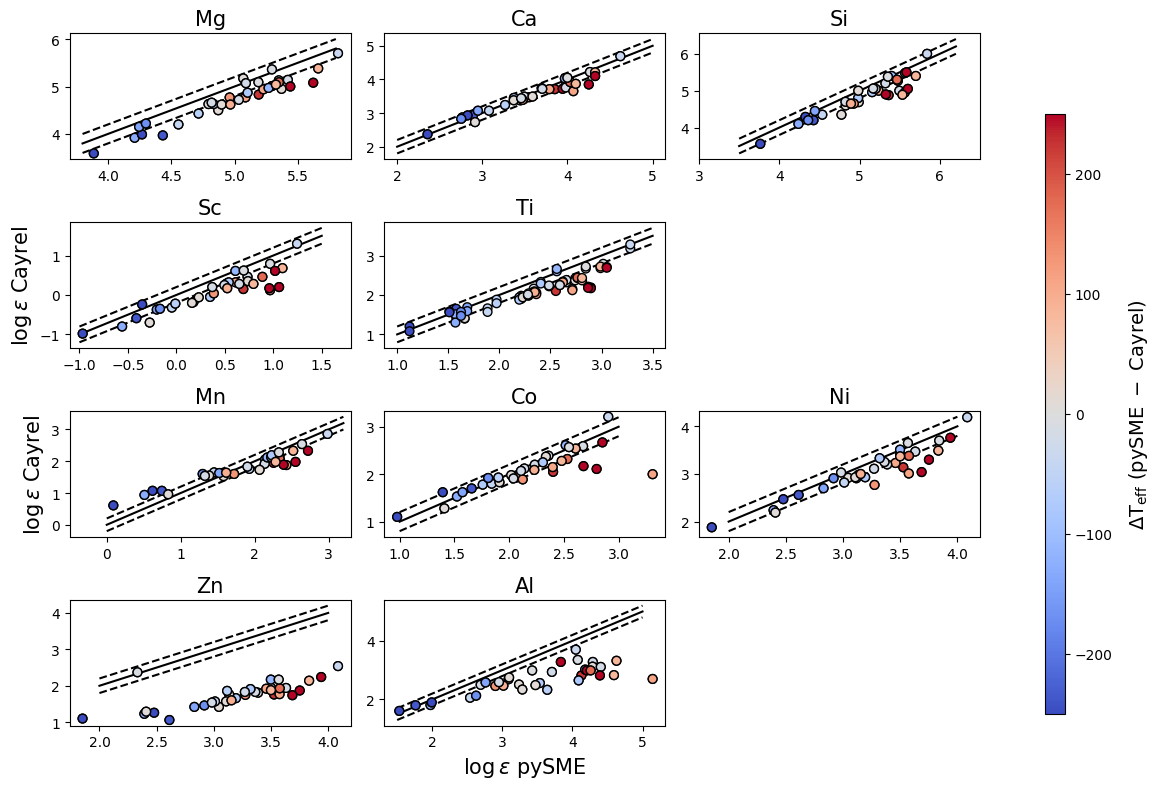

In [93]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10,8), dpi=100)

plt.subplot(4,3,1)
plt.title('Mg', size=15)
scatter = plt.scatter(cayrel_merged.logeMg.values, cayrel_merged.logeMg_c04.values, s=40, ec='k', c=cayrel_merged.teff.values - cayrel_merged.teff_cayrel.values, vmin=-250, vmax=250, cmap=plt.cm.coolwarm)
# plt.colorbar()
x = np.linspace(3.8, 5.8)
plt.plot(x,x, color='k', zorder=0)
plt.plot(x,x+0.2, color='k', zorder=0, ls='--')
plt.plot(x,x-0.2, color='k', zorder=0, ls='--')

plt.subplot(4,3,2)
plt.title('Ca', size=15)
plt.scatter(cayrel_merged.logeCa.values, cayrel_merged.logeCa_c04.values, s=40, ec='k', c=cayrel_merged.teff.values - cayrel_merged.teff_cayrel.values, vmin=-250, vmax=250, cmap=plt.cm.coolwarm)
# plt.colorbar()
x = np.linspace(2.0, 5.0)
plt.plot(x,x, color='k', zorder=0)
plt.plot(x,x+0.2, color='k', zorder=0, ls='--')
plt.plot(x,x-0.2, color='k', zorder=0, ls='--')

plt.subplot(4,3,3)
plt.title('Si', size=15)
plt.scatter(cayrel_merged.logeSi.values, cayrel_merged.logeSi_c04.values, s=40, ec='k', c=cayrel_merged.teff.values - cayrel_merged.teff_cayrel.values, vmin=-250, vmax=250, cmap=plt.cm.coolwarm)
# plt.colorbar()
x = np.linspace(3.5, 6.2)
plt.plot(x,x, color='k', zorder=0)
plt.plot(x,x+0.2, color='k', zorder=0, ls='--')
plt.plot(x,x-0.2, color='k', zorder=0, ls='--')
plt.xlim(3,6.5)

# ['mg', 'ca', 'si', 'sc', 'ti', 'cr', 'mn', 'co', 'ni', 'zn', 'al', 'k']

plt.subplot(4,3,4)
plt.title('Sc', size=15)
plt.scatter(cayrel_merged.logeSc.values, cayrel_merged.logeSc_c04.values, s=40, ec='k', c=cayrel_merged.teff.values - cayrel_merged.teff_cayrel.values, vmin=-250, vmax=250, cmap=plt.cm.coolwarm)
# plt.colorbar()
x = np.linspace(-1,1.5)
plt.plot(x,x, color='k', zorder=0)
plt.plot(x,x+0.2, color='k', zorder=0, ls='--')
plt.plot(x,x-0.2, color='k', zorder=0, ls='--')
plt.ylabel(r'$\log{\epsilon}$ Cayrel', size=15)
plt.xlim(-1.1,1.8)

plt.subplot(4,3,5)
plt.title('Ti', size=15)
plt.scatter(cayrel_merged.logeTi.values, cayrel_merged.logeTi_c04.values, s=40, ec='k', c=cayrel_merged.teff.values - cayrel_merged.teff_cayrel.values, vmin=-250, vmax=250, cmap=plt.cm.coolwarm)
# plt.colorbar()
x = np.linspace(1,3.5)
plt.plot(x,x, color='k', zorder=0)
plt.plot(x,x+0.2, color='k', zorder=0, ls='--')
plt.plot(x,x-0.2, color='k', zorder=0, ls='--')

plt.subplot(4,3,6)
plt.axis('off')
# plt.title('Cr')
# plt.scatter(cayrel_cr.logeCr.values, cayrel_cr.loge.values, s=40, ec='k', c=cayrel_cr.teff.values - cayrel_cr.teff_cayrel.values, vmin=-250, vmax=250)
# plt.colorbar()
# x = np.linspace(2,4.5)
# plt.plot(x,x, color='k', zorder=0)
# plt.plot(x,x+0.2, color='k', zorder=0, ls='--')
# plt.plot(x,x-0.2, color='k', zorder=0, ls='--')
# plt.xlim(2,5)

# ['mg', 'ca', 'si', 'sc', 'ti', 'cr', 'mn', 'co', 'ni', 'zn', 'al', 'k']

plt.subplot(4,3,7)
plt.title('Mn', size=15)
plt.scatter(cayrel_merged.logeMn.values, cayrel_merged.logeMn_c04.values, s=40, ec='k', c=cayrel_merged.teff.values - cayrel_merged.teff_cayrel.values, vmin=-250, vmax=250, cmap=plt.cm.coolwarm)
# plt.colorbar()
x = np.linspace(0.0,3.2)
plt.plot(x,x, color='k', zorder=0)
plt.plot(x,x+0.2, color='k', zorder=0, ls='--')
plt.plot(x,x-0.2, color='k', zorder=0, ls='--')
plt.xlim(-0.5,3.3)
plt.ylabel(r'$\log{\epsilon}$ Cayrel', size=15)

plt.subplot(4,3,8)
plt.title('Co', size=15)
plt.scatter(cayrel_merged.logeCo.values, cayrel_merged.logeCo_c04.values, s=40, ec='k', c=cayrel_merged.teff.values - cayrel_merged.teff_cayrel.values, vmin=-250, vmax=250, cmap=plt.cm.coolwarm)
# plt.colorbar()
x = np.linspace(1,3)
plt.plot(x,x, color='k', zorder=0)
plt.plot(x,x+0.2, color='k', zorder=0, ls='--')
plt.plot(x,x-0.2, color='k', zorder=0, ls='--')

plt.subplot(4,3,9)
plt.title('Ni', size=15)
plt.scatter(cayrel_merged.logeNi.values, cayrel_merged.logeNi_c04.values, s=40, ec='k', c=cayrel_merged.teff.values - cayrel_merged.teff_cayrel.values, vmin=-250, vmax=250, cmap=plt.cm.coolwarm)
# plt.colorbar()
x = np.linspace(2,4)
plt.plot(x,x, color='k', zorder=0)
plt.plot(x,x+0.2, color='k', zorder=0, ls='--')
plt.plot(x,x-0.2, color='k', zorder=0, ls='--')

plt.subplot(4,3,10)
plt.title('Zn', size=15)
plt.scatter(cayrel_merged.logeZn.values, cayrel_merged.logeZn_c04.values, s=40, ec='k', c=cayrel_merged.teff.values - cayrel_merged.teff_cayrel.values, vmin=-250, vmax=250, cmap=plt.cm.coolwarm)
# plt.colorbar()
x = np.linspace(2,4)
plt.plot(x,x, color='k', zorder=0)
plt.plot(x,x+0.2, color='k', zorder=0, ls='--')
plt.plot(x,x-0.2, color='k', zorder=0, ls='--')

# ['mg', 'ca', 'si', 'sc', 'ti', 'cr', 'mn', 'co', 'ni', 'zn', 'al', 'k']

plt.subplot(4,3,11)
plt.title('Al', size=15)
plt.scatter(cayrel_merged.logeAl.values, cayrel_merged.logeAl_c04.values, s=40, ec='k', c=cayrel_merged.teff.values - cayrel_merged.teff_cayrel.values, vmin=-250, vmax=250, cmap=plt.cm.coolwarm)
# plt.colorbar()
x = np.linspace(1.5, 5)
plt.plot(x,x, color='k', zorder=0)
plt.plot(x,x+0.2, color='k', zorder=0, ls='--')
plt.plot(x,x-0.2, color='k', zorder=0, ls='--')
plt.xlabel(r'$\log{\epsilon}$ pySME', size=15)

plt.subplot(4,3,12)
plt.axis('off')
# plt.title('K')
# plt.scatter(cayrel_k.logeK.values, cayrel_k.loge.values, s=40, ec='k', c=cayrel_k.teff.values - cayrel_k.teff_cayrel.values, vmin=-250, vmax=250)
# plt.colorbar()
# x = np.linspace(2,5)
# plt.plot(x,x, color='k', zorder=0)
# plt.plot(x,x+0.2, color='k', zorder=0, ls='--')
# plt.plot(x,x-0.2, color='k', zorder=0, ls='--')

cbar_ax = fig.add_axes([1.05, 0.10, 0.02, 0.75]) #[left, bottom, width, height]
cb = fig.colorbar(scatter, cax=cbar_ax)
cb.set_label(r'${\rm \Delta T_{eff}\ (pySME\ -\ Cayrel)}$', labelpad=10, fontsize=14)

plt.tight_layout()
# plt.savefig('plots/UVES_pySME_Cayrel_element_comparison.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [94]:
cayrel_lelements.query('species == "Al"').head(2)

,spec_id,feh_c04,species,loge,is_limit_am,am,is_limit_afe,afe,eafe,nlines_c04
5,01_HD2796,-2.47,Al,3.35,False,-3.12,False,-0.66,NaN,2.0
24,02_HD122563,-2.82,Al,3.28,False,-3.19,False,-0.38,NaN,2.0


In [95]:
delta_teff = 200.
print ('Mg: %2.2f' %np.mean((cayrel_merged.logeMg.values - cayrel_merged.logeMg_c04.values)[np.abs(cayrel_merged.teff.values - cayrel_merged.teff_cayrel.values) < delta_teff]))
print ('Ca: %2.2f' %np.mean((cayrel_merged.logeCa.values - cayrel_merged.logeCa_c04.values)[np.abs(cayrel_merged.teff.values - cayrel_merged.teff_cayrel.values) < delta_teff]))
print ('Si: %2.2f' %np.nanmean((cayrel_merged.logeSi.values - cayrel_merged.logeSi_c04.values)[np.abs(cayrel_merged.teff.values - cayrel_merged.teff_cayrel.values) < delta_teff]))
# print ('Mn: %2.2f' %np.std((cayrel_mn.logeMn.values - cayrel_mn.loge.values)[np.abs(cayrel_mn.teff.values - cayrel_mn.teff_cayrel.values) < delta_teff]))
# print ('Al: %2.2f' %np.std((cayrel_al.logeAl.values - cayrel_al.loge.values)[np.abs(cayrel_al.logeAl.values < 4.)]))

Mg: 0.22
Ca: 0.05
Si: 0.20


In [98]:
#Saving the Cayrel light elements file

In [99]:
cayrel_merged.to_csv('tmp_merged/cayrel_atm_fe_cn_corr_lelements.csv', header=True, index=False)

In [100]:
#Old code from here!

In [74]:
lines = pd.read_csv('tmp_cayrel/cayrel_elem_lines_na_35_CS31082_01.csv')

In [75]:
lines.query('ena_sme < 1. and na > 0.0 and ena_sme != 0.0')

,spec_id,species,wl_line,excit,gflog,na,ena_sme,ena_fit,n_iter_na
0,35_CS31082_01,Na 1,3883.90,-0.0000,-12.008,9.823,0.404,0.053,23
8,35_CS31082_01,Na 1,4276.77,2.1044,-4.274,8.148,0.526,0.323,8
10,35_CS31082_01,Na 1,4291.00,2.1044,-4.094,9.652,0.660,0.093,24
11,35_CS31082_01,Na 1,4321.40,2.1023,-3.016,7.252,0.939,1.377,6
16,35_CS31082_01,Na 1,4393.34,2.1044,-2.895,7.362,0.665,0.345,5
17,35_CS31082_01,Na 1,4419.88,2.1023,-3.288,8.200,0.812,1.070,7
19,35_CS31082_01,Na 1,4494.18,2.1023,-2.633,7.218,0.525,0.253,13
23,35_CS31082_01,Na 1,4664.81,2.1023,-2.371,7.539,0.046,0.034,14
25,35_CS31082_01,Na 1,4747.94,2.1023,-2.884,7.852,0.381,0.143,12
26,35_CS31082_01,Na 1,4751.82,2.1044,-3.583,7.836,0.476,0.136,9


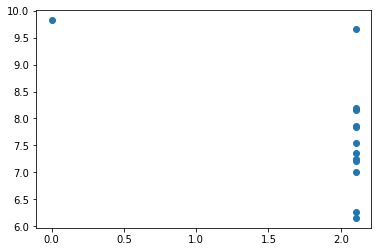

In [77]:
plt.scatter(lines.query('ena_sme < 1. and na > 0.0 and ena_sme != 0.0').excit.values, lines.query('ena_sme < 1. and na > 0.0 and ena_sme != 0.0').na.values)
plt.show()

In [10]:
#Plots for Kim

In [11]:
sme_mn1 = SME_Structure.load('sme_save/cayrel_elem_mn_lines_24_CS22952_15_4030.76.sme')
sme_mn2 = SME_Structure.load('sme_save/cayrel_elem_mn_lines_24_CS22952_15_4033.70.sme')

[2025-04-04 11:34:32,070] [INFO] [sme:load:839]: Loading SME file sme_save/cayrel_elem_mn_lines_24_CS22952_15_4030.76.sme


INFO - Loading SME file sme_save/cayrel_elem_mn_lines_24_CS22952_15_4030.76.sme


[2025-04-04 11:34:32,870] [INFO] [sme:load:839]: Loading SME file sme_save/cayrel_elem_mn_lines_24_CS22952_15_4033.70.sme


INFO - Loading SME file sme_save/cayrel_elem_mn_lines_24_CS22952_15_4033.70.sme


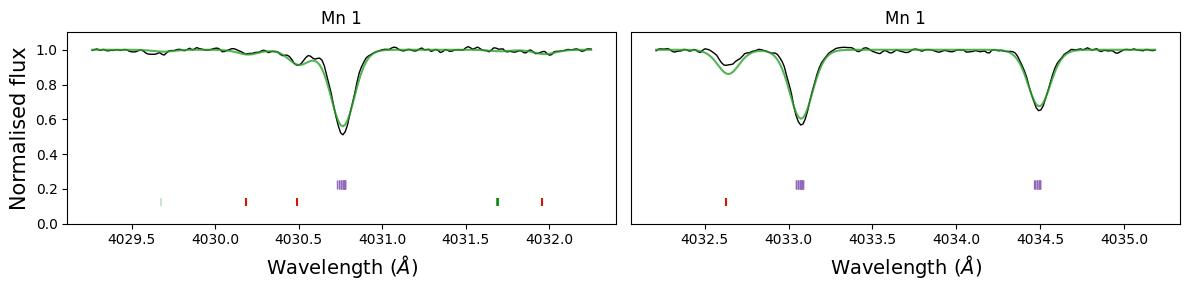

In [12]:
plt.figure(figsize=(12,3), dpi=100)
plt.subplots_adjust(wspace=0.01)

plt.subplot(1,2,1)

plt.plot(sme_mn1.wave.data, sme_mn1.spec.data, color='k', lw=1)
plt.plot(sme_mn1.wave.data, sme_mn1.synth.data, color='C2', lw=1.5, alpha=0.8)

elems_to_include = ['Mn 1']
for wline, species in pd.DataFrame(sme_mn1.linelist)[['wlcent', 'species']].values:
    if 'H 1' in species:
        continue
    if (species == 'Fe 1') | (species == 'Fe 2'):
        plt.vlines(wline, 0.1, 0.15, color='r')
        # plt.annotate(text='%s' %species, xy=(wline-0.09, 0.3), rotation=90, fontsize=10)
    if species not in elems_to_include:
        plt.vlines(wline, 0.1, 0.15, color='g', alpha=0.2)
        # plt.annotate(text='%s' %species, xy=(wline-0.09, 0.3), rotation=90, fontsize=10)
        continue
    
    plt.vlines(wline, 0.20, 0.25, color='C4', lw=1)
    # plt.annotate(text='%s' %species, xy=(wline-0.09, 0.3), rotation=90, fontsize=10)

plt.title('%s' %elems_to_include[0])
plt.ylim(0.0, 1.1)
plt.xlabel(r'Wavelength ($\AA$)', size=14)
plt.ylabel('Normalised flux', size=15)


plt.subplot(1,2,2)

plt.plot(sme_mn2.wave.data, sme_mn2.spec.data, color='k', lw=1)
plt.plot(sme_mn2.wave.data, sme_mn2.synth.data, color='C2', lw=1.5, alpha=0.8)

elems_to_include = ['Mn 1']
for wline, species in pd.DataFrame(sme_mn2.linelist)[['wlcent', 'species']].values:
    if 'H 1' in species:
        continue
    if (species == 'Fe 1') | (species == 'Fe 2'):
        plt.vlines(wline, 0.1, 0.15, color='r')
        # plt.annotate(text='%s' %species, xy=(wline-0.09, 0.3), rotation=90, fontsize=10)
    if species not in elems_to_include:
        plt.vlines(wline, 0.1, 0.15, color='g', alpha=0.2)
        # plt.annotate(text='%s' %species, xy=(wline-0.09, 0.3), rotation=90, fontsize=10)
        continue
    
    plt.vlines(wline, 0.20, 0.25, color='C4', lw=1)
    # plt.annotate(text='%s' %species, xy=(wline-0.09, 0.3), rotation=90, fontsize=10)

plt.title('%s' %elems_to_include[0])
plt.yticks([])
plt.ylim(0.0, 1.1)
plt.xlabel(r'Wavelength ($\AA$)', size=14)

plt.tight_layout()
plt.savefig('plots/cayrel_mn_kvenn_issi.pdf', dpi=100)
plt.show()

In [16]:
sme_mn1.fitresults.values

array([4.54789092])

In [149]:
#Merging of files per element

In [38]:
# elem_to_merge = 'zn' # ['mg', 'ca', 'si', 'sc', 'ti', 'cr', 'mn', 'co', 'ni', 'zn', 'al']

In [107]:
# os.system('cat tmp_cayrel/cayrel_elem_lines_%s_* > tmp_merged/cayrel_elem_lines_%s.csv' %(elem_to_merge,elem_to_merge))
# columns = pd.read_csv('tmp_cayrel/cayrel_elem_lines_%s_01_HD2796.csv' %elem_to_merge).columns
# lines_mn = pd.read_csv('tmp_merged/cayrel_elem_lines_%s.csv' %elem_to_merge, names=columns, comment='s')

In [177]:
lines_mn.spec_id.unique()

array(['01_HD2796', '02_HD122563', '03_HD186478', '04_BD17_3248',
       '05_BD18_5550', '06_Eric38_245', '07_BS16467_62', '08_BS16477_3',
       '09_BS17569_49', '10_CS22169_35', '11_CS22172_2', '12_CS22186_25',
       '13_CS22189_09', '14_CS22873_55', '15_CS22873_166',
       '16_CS22878_101', '17_CS22885_96', '18_CS22891_209',
       '19_CS22892_52', '20_CS22896_154', '21_CS22897_8', '22_CS22948_66',
       '23_CS22949_37', '24_CS22952_15', '25_CS22953_3', '26_CS22956_50',
       '27_CS22966_57', '28_CS22968_14', '29_CS29491_53', '30_CS29495_41',
       '31_CS29502_42', '32_CS29516_24', '33_CS29518_51', '34_CS30325_94',
       '35_CS31082_01'], dtype=object)

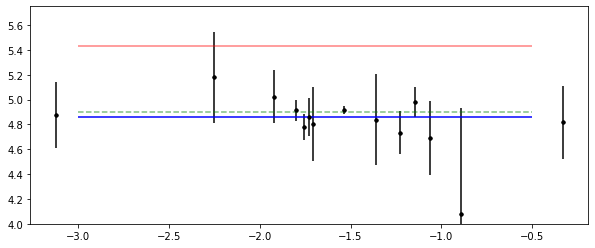

In [212]:
spec_id = '33_CS29518_51'
plt.figure(figsize=(10,4))
plt.scatter(lines_mn.query('spec_id == "%s" and emn_sme < 1.0' %spec_id).excit.values, lines_mn.query('spec_id == "%s" and emn_sme < 1.0' %spec_id).mn.values, color='k', s=10)
plt.errorbar(lines_mn.query('spec_id == "%s" and emn_sme < 1.0' %spec_id).excit.values, lines_mn.query('spec_id == "%s" and emn_sme < 1.0' %spec_id).mn.values, fmt='.k', 
            yerr=lines_mn.query('spec_id == "%s" and emn_sme < 1.0' %spec_id).emn_sme.values)
plt.hlines(np.average(lines_mn.query('spec_id == "%s" and emn_sme < 1.0' %spec_id).mn.values, 
                      weights=1./lines_mn.query('spec_id == "%s" and emn_sme < 1.0' %spec_id).emn_sme.values**2.), -3, -0.5, color='g', ls='--', alpha=0.5)
plt.hlines(solar.abund.get_element('Mn'), -3, -0.5, color='r', alpha=0.5)
plt.hlines(cayrel_mn.query('spec_id == "%s"' %spec_id).loge.values - cayrel_mn.query('spec_id == "%s"' %spec_id).monh.values, -3, -0.5, color='b')

plt.ylim(4.0, 5.75)
plt.show()

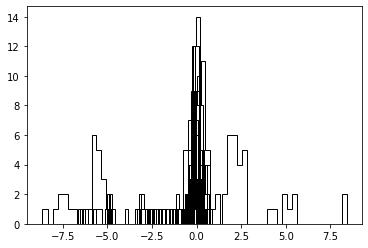

In [132]:
for line in np.unique(lines_mg.wl_line.values):
    try:
        plt.hist(lines_mn.query('wl_line == %4.2f' %line).mn.values - lines_mn.query('wl_line == %4.2f' %line).mn.values[1], bins=30, histtype='step', color='k', stacked=True)
    except:
        continue
# plt.xlim(-4, 2)
plt.show()

In [41]:
#Plots for checking

In [63]:
# sme = SME_Structure.load('sme_save/Cayrel_01_HD2796.sme')
# sme = SME_Structure.load('sme_save/Cayrel_03_HD186478.sme')
# sme = SME_Structure.load('sme_save/cayrel_elem_ba_35_CS31082_01.sme')
sme = SME_Structure.load('sme_save/cayrel_elem_pr_lines_35_CS31082_01_5259.71.sme')

[2025-04-22 11:23:42,210] [INFO] [sme:load:839]: Loading SME file sme_save/cayrel_elem_pr_lines_35_CS31082_01_5259.71.sme


INFO - Loading SME file sme_save/cayrel_elem_pr_lines_35_CS31082_01_5259.71.sme


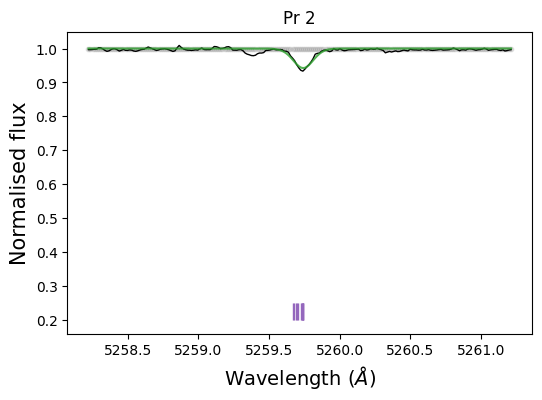

In [65]:
plt.figure(figsize=(6,4), dpi=100)

plt.plot(sme.wave.data, sme.spec.data, color='k', lw=1)
# plt.errorbar(sme.wave.data, sme.spec.data, fmt='k.', yerr=0.1*sme.uncs.data, lw=1, ms=1)
plt.plot(sme.wave.data, sme.synth.data, color='C2', lw=1.5, alpha=0.8)

plt.scatter(sme.wave.data, sme.mask.data, s=10, color='grey', alpha=0.2)

elems_to_include = ['Pr 2']
for wline, species in pd.DataFrame(sme.linelist)[['wlcent', 'species']].values:
    if 'H 1' in species:
        continue
    if (species == 'Fe 1') | (species == 'Fe 2'):
        plt.vlines(wline, 0.1, 0.15, color='r')
    if species not in elems_to_include:
        plt.vlines(wline, 0.1, 0.15, color='g', alpha=0.2)
        # plt.annotate(text='%s' %species, xy=(wline-0.09, 0.3), rotation=90, fontsize=10)
        continue
    
    plt.vlines(wline, 0.20, 0.25, color='C4', lw=1)
    # plt.annotate(text='%s' %species, xy=(wline-0.09, 0.3), rotation=90, fontsize=10)
plt.title('%s' %elems_to_include[0])
# plt.xlim(4000, 4020)
# plt.xlim(4128, 4131.5) #Eu
# plt.xlim(4129.5, 4130) #Eu
# plt.xlim(4203, 4207) #Eu
# plt.xlim(3815, 3825)

# plt.xlim(4125, 4135) #Ba
# plt.xlim(4164, 4168) #Ba
# plt.xlim(4285, 4290) #Ba
# plt.xlim(4552, 4556) #Ba
# plt.xlim(4932, 4936) #Ba

# plt.xlim(4213, 4219) #Sr
# plt.xlim(4075, 4080) #Sr

# plt.xlim(3937, 3952) #Al
# plt.ylim(0.0, 1.1)

plt.xlabel(r'Wavelength ($\AA$)', size=14)
plt.ylabel('Normalised flux', size=15)
plt.show()

In [66]:
sme.fitresults.values

array([2.11338585])

In [67]:
sme.fitresults.values+sme.monh, sme.vrad

(array([-0.49087535]), array([0.54010985]))

In [68]:
sme.fitresults.fit_uncertainties, sme.fitresults.uncertainties

([0.016596916149868905], array([0.09969072]))

In [69]:
sme.fitresults.values

array([2.11338585])

In [70]:
elem = 'pr'
lines = pd.read_csv('tmp_cayrel/cayrel_elem_lines_%s_35_CS31082_01.csv' %elem)
lines['log%s' %elem.upper()] = lines['%s' %elem].values + cayrel.query('spec_id == "35_CS31082_01"').monh.values

In [71]:
lines = lines.query('e%s_sme < 0.5 and e%s_sme > 0.0 and %s < 10.0' %(elem, elem, elem))

In [72]:
lines

,spec_id,species,wl_line,excit,gflog,pr,epr_sme,epr_fit,n_iter_pr,logPR
0,35_CS31082_01,Pr 2,4061.78,0.6333,-1.690,2.082,0.073,0.073,12,-0.522261
1,35_CS31082_01,Pr 2,4062.30,0.4219,-2.963,2.070,0.058,0.079,12,-0.534261
2,35_CS31082_01,Pr 2,5219.48,0.7953,-2.189,2.061,0.122,0.013,18,-0.543261
3,35_CS31082_01,Pr 2,5259.71,0.6334,-1.962,2.113,0.100,0.017,20,-0.491261


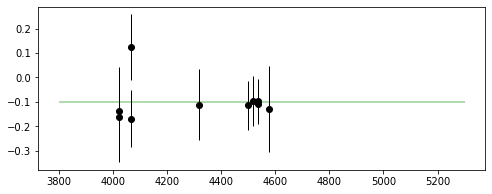

In [150]:
plt.figure(figsize=(8,3))

plt.scatter(lines.wl_line.values, lines['log%s' %elem.upper()].values, color='k')
plt.errorbar(lines.wl_line.values, lines['log%s' %elem.upper()].values, fmt='k.', yerr=lines['e%s_sme' %elem].values, lw=1)
plt.hlines(np.average(lines['log%s' %elem.upper()].values, weights=1./lines['e%s_sme' %elem].values**2.), 3800, 5300, color='C2', alpha=0.5, zorder=0)
plt.show()

In [151]:
lines.wl_line.values

array([4022.05, 4022.97, 4066.73, 4068.32, 4318.93, 4499.48, 4519.63,
       4537.23, 4538.25, 4578.64])

In [152]:
np.average(lines['log%s' %elem.upper()].values, weights=1./lines['e%s_sme' %elem].values**2.)

-0.09857645176076027